In [1]:
%cd C:\Users\leoma\Desktop\projects\Modelos-de-Pronosticos-Series-Temporales-Python\TensorFlow Structural Time Series

c:\Users\leoma\Desktop\projects\Modelos-de-Pronosticos-Series-Temporales-Python\TensorFlow Structural Time Series


# Libraries and Data

In [2]:
#libraries
import pandas as pd
import numpy as np
import tensorflow_probability as tfp

In [3]:
#load the data
df = pd.read_csv('Udemy_wikipedia_visits.csv',
                 index_col="Date",
                 parse_dates=True)
df.head()

,Udemy,Easter,Christmas
Date,,,
2016-01-01,311,0,0
2016-01-02,564,0,0
2016-01-03,517,0,0
2016-01-04,652,0,0
2016-01-05,756,0,0


<AxesSubplot: xlabel='Date'>

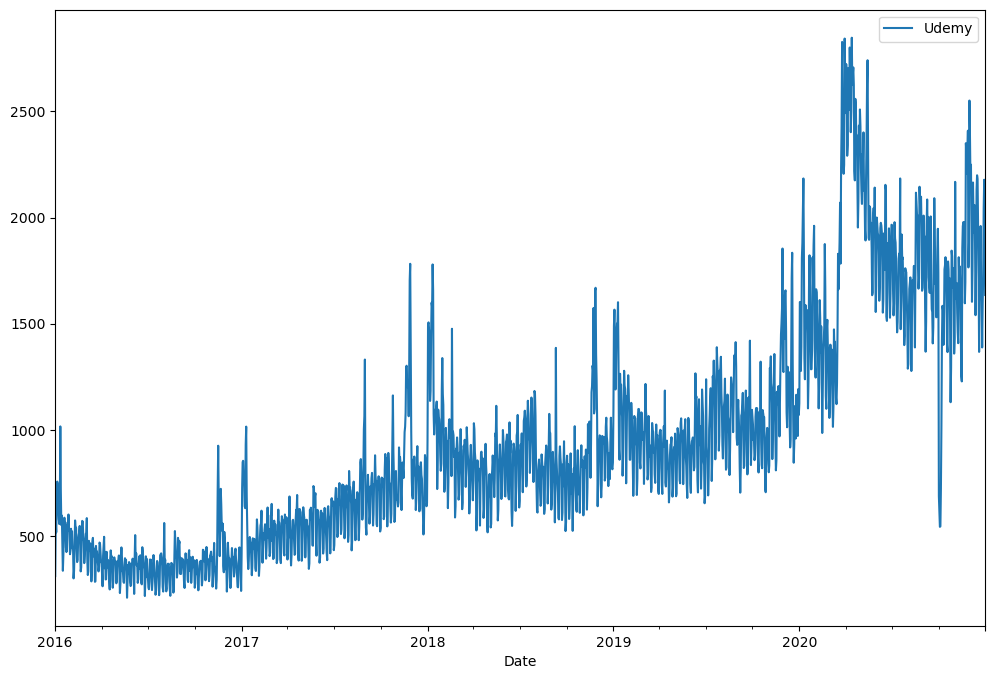

In [4]:
#Visualization
df["Udemy"].plot(figsize=(12,8), legend=True)

In [5]:
#Set frecuency
df=df.asfreq("D")
df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1827, freq='D')

# Regressors

1. Set as Regressors Easter and Christmas variables

In [6]:
# Isolate the regressors
exog = df.iloc[:,1:]
exog.head()

,Easter,Christmas
Date,,
2016-01-01,0,0
2016-01-02,0,0
2016-01-03,0,0
2016-01-04,0,0
2016-01-05,0,0


In [7]:
#matrix
exog = np.asmatrix(df.iloc[:,1:]).astype(np.float64)
exog[1]

matrix([[0., 0.]])

In [8]:
# linear regression
regressors = tfp.sts.LinearRegression(design_matrix = exog,
                                      name = "regressors")

# Training and Test Set

2. Split into Training and Test Set and Isolate y

In [11]:
test_days = 31
training_set = df.iloc[:-test_days,:]
test_set=  df.iloc[-test_days:, :]

In [12]:
# # Isolating dependent variable
y = training_set.Udemy.astype(np.float64)
y[:5]

Date
2016-01-01    311.0
2016-01-02    564.0
2016-01-03    517.0
2016-01-04    652.0
2016-01-05    756.0
Freq: D, Name: Udemy, dtype: float64

# Seasonality

3. Create a weekly and monthly seasonality objects

In [18]:
weekday_effect = tfp.sts.Seasonal(num_seasons= 7, 
                                   num_steps_per_season= 1, 
                                   observed_time_series= y, 
                                   name='weekday_effect')

In [16]:
#vemos si tenemos el problema del año bisiesto con los datos.. para esto, vemos la longitud de los datos.
df.head(1)

,Udemy,Easter,Christmas
Date,,,
2016-01-01,311,0,0


In [17]:
df.tail(1)

,Udemy,Easter,Christmas
Date,,,
2020-12-31,1635,0,0


In [20]:
nums_days_per_month = np.array(
    [[31,29,31,30,31,30,31,31,30,31,30,31], # 2016 Leap Yeah
     [31,28,31,30,31,30,31,31,30,31,30,31],
     [31,28,31,30,31,30,31,31,30,31,30,31],
     [31,28,31,30,31,30,31,31,30,31,30,31],]
)

In [21]:
# Monthly Seasonality
monthly_effect = tfp.sts.Seasonal(num_seasons= 12, 
                                   num_steps_per_season= nums_days_per_month, 
                                   observed_time_series= y, 
                                   name='monthly_effect')

# Trend and Seasonality

4. Create Trend and Autoregressive components

In [22]:
# Trend
trend = tfp.sts.LocalLinearTrend(observed_time_series=y, 
                                 name="trend")

In [23]:
# autoregressive
autoregressive = tfp.sts.Autoregressive(order=1, observed_time_series=y, name='autoregressive')

# Model

5. Create Tensorflow model and fit it with Hamiltonion Monte Carlo

In [24]:
model = tfp.sts.Sum([regressors,
                     weekday_effect,
                     monthly_effect,
                     autoregressive,
                     trend],
                     observed_time_series = y)

In [25]:
# Fitting
samples, kernel_results = tfp.sts.fit_with_hmc(model, y, num_results=10, 
                                               num_warmup_steps=10, 
                                               num_leapfrog_steps=5, 
                                               num_variational_steps=15, 
                                               seed=1502)

c:\Users\leoma\Desktop\projects\env\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


# Forecasting and Viz

6. Predict 30 days and add index to the predictions

In [26]:
forecast = tfp.sts.forecast(model, 
                            y, 
                            parameter_samples=samples, 
                            num_steps_forecast=31)

In [27]:
#predictions
predictions_tfp = pd.Series(forecast.mean()[:,0], name="TFP")
predictions_tfp.index = test_set.index

7. Visualize forecast training and test data

<AxesSubplot: xlabel='Date'>

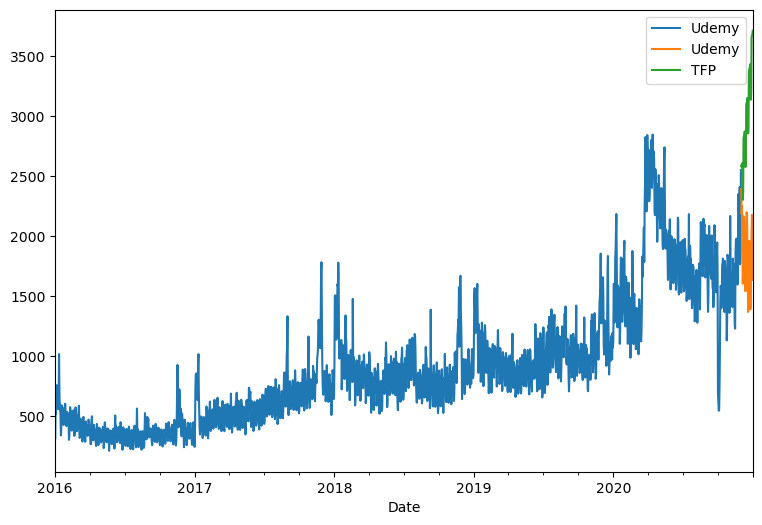

In [28]:
training_set.Udemy.plot(figsize=(9,6), 
                        legend=True)
test_set.Udemy.plot(legend=True)
predictions_tfp.plot(legend=True)

In [ ]:
# Resultado malo, es el costo de usar pocos resultados (sacrificar tiempo por calidad )en #fitting 

<AxesSubplot: xlabel='Date'>

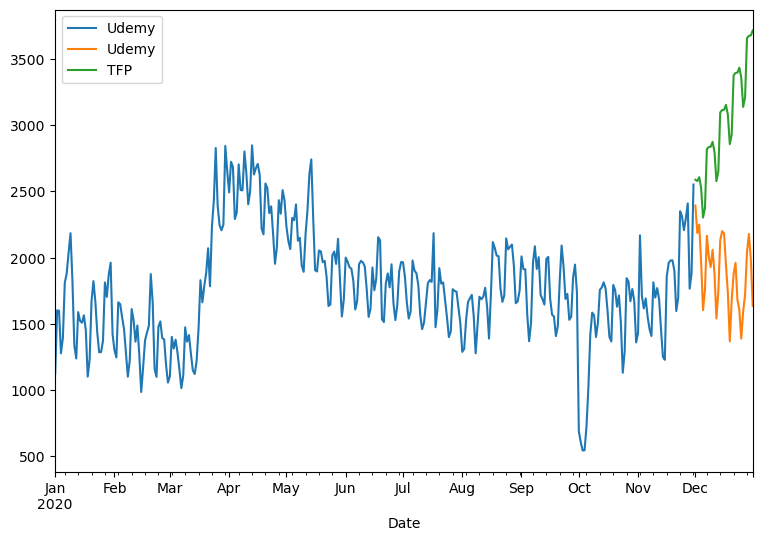

In [30]:
training_set.Udemy['2020-01-01':].plot(figsize=(9,6), 
                        legend=True)
test_set.Udemy.plot(legend=True)
predictions_tfp.plot(legend=True)